# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import ast
import json

In [2]:
train_df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/train.csv')
test_df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/sample_submission.csv')

## EDA

In [3]:
train_df.dtypes

id                 int64
model_a           object
model_b           object
prompt            object
response_a        object
response_b        object
winner_model_a     int64
winner_model_b     int64
winner_tie         int64
dtype: object

In [4]:
train_df.model_a.value_counts()

model_a
gpt-4-1106-preview          3678
gpt-3.5-turbo-0613          3553
gpt-4-0613                  3099
claude-2.1                  2859
gpt-4-0314                  2087
                            ... 
falcon-180b-chat             145
openchat-3.5-0106            108
qwen1.5-7b-chat              106
qwen1.5-4b-chat              100
mistral-7b-instruct-v0.2      54
Name: count, Length: 64, dtype: int64

In [5]:
train_df['prompt'] = train_df['prompt'].apply(ast.literal_eval)

test_df['prompt'] = test_df['prompt'].apply(ast.literal_eval)

In [6]:
train_df['response_a'] = train_df['response_a'].apply(lambda x: json.loads(x))

train_df['response_b'] = train_df['response_b'].apply(lambda x: json.loads(x))

In [7]:
test_df['response_a'] = test_df['response_a'].apply(lambda x: json.loads(x))

test_df['response_b'] = test_df['response_b'].apply(lambda x: json.loads(x))

In [12]:
# single_element_check = train_df['prompt'].apply(lambda x: len(x) == 1)

In [8]:
train_df.winner_model_a.value_counts()

winner_model_a
0    37413
1    20064
Name: count, dtype: int64

In [16]:
# train_df[single_element_check]

In [9]:
train_df.iloc[1].prompt

['What is the difference between marriage license and marriage certificate?',
 'How can I get both of them as quick as possible in California ',
 'What is the minimal time to get them? 1 day or 10 days?']

In [ ]:
(train_df.iloc[1].response_a)

we are evaluating not the prompt-response, but chat instead.  
there may be corrupted values
Check dist of target, id.
Maybe you need to split by id.  
the missing values mean that we ask the model `Enough`

Additional data: https://huggingface.co/datasets/lmsys/chatbot_arena_conversations

In [11]:
train_df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,[Is it morally right to try to have a certain ...,[The question of whether it is morally right t...,"[As an AI, I don't have personal beliefs or op...",1,0,0
1,53567,koala-13b,gpt-4-0613,[What is the difference between marriage licen...,[A marriage license is a legal document that a...,[A marriage license and a marriage certificate...,0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,[explain function calling. how would you call ...,[Function calling is the process of invoking o...,[Function calling is the process of invoking a...,0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,[How can I create a test set for a very rare c...,[Creating a test set for a very rare category ...,[When building a classifier for a very rare ca...,1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,[What is the best way to travel from Tel-Aviv ...,[The best way to travel from Tel Aviv to Jerus...,[The best way to travel from Tel-Aviv to Jerus...,0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[A simple mnemonic for π:\n""How I wish I could...","[Sure, let's break it down:\n\n1. ""How"" has 3 ...",[Here is how that mnemonic represents the digi...,1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[In python, implement a naive Bayes with gauss...",[Here is an implementation of a naive Bayes cl...,[Sure! Here's an implementation of a naive Bay...,1,0,0
57474,4294710549,claude-1,alpaca-13b,"[is it unethical to work on building weapons?,...",[Working on weapons technology raises some eth...,[It depends on the context. Weapons can be use...,1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[If a bait contains 0,0025% bromadiolon then h...",[Bromadiolone is a rodenticide which is most o...,"[As an AI language model, I do not promote or ...",0,1,0


In [12]:
def check_non_string_items(lst):
    # Return True if there is any non-string item in the list, otherwise False
    return any(not isinstance(item, str) for item in lst)

In [13]:
x = train_df['response_a'].apply(check_non_string_items)

In [14]:
train_df['response_a'] = train_df['response_a'].apply(lambda x: x if isinstance(x, list) else [])
train_df['response_b'] = train_df['response_b'].apply(lambda x: x if isinstance(x, list) else [])

In [15]:
test_df['response_a'] = test_df['response_a'].apply(lambda x: x if isinstance(x, list) else [])
test_df['response_b'] = test_df['response_b'].apply(lambda x: x if isinstance(x, list) else [])

In [16]:
def average_length(lst):
    if not lst:
        return 0
    lengths = [len(item) if isinstance(item, str) else 0 for item in lst]  # Handle None or non-string types inside the list
    return sum(lengths) / len(lst) if lengths else 0

In [17]:
# Calculate the number of strings and the average string length for 'response_a'
train_df['response_a_len'] = train_df['response_a'].apply(len)
train_df['response_a_avg_len'] = train_df['response_a'].apply(average_length)

In [18]:
test_df['response_a_len'] = test_df['response_a'].apply(len)
test_df['response_a_avg_len'] = test_df['response_a'].apply(average_length)

<Axes: >

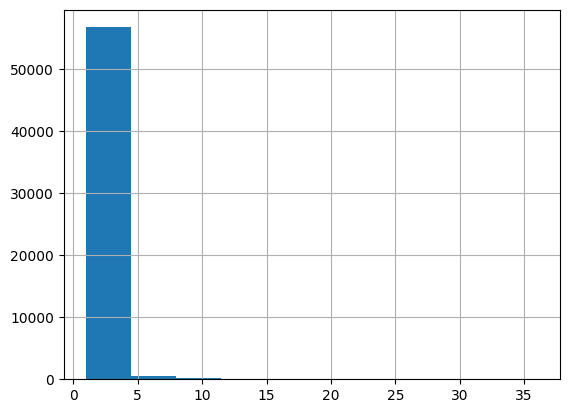

In [19]:
train_df['response_a_len'].hist()

<Axes: >

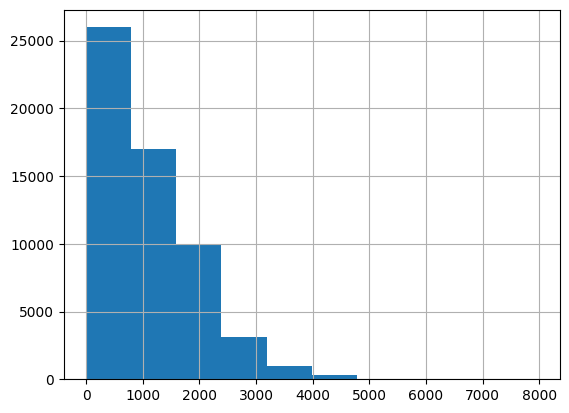

In [20]:
train_df['response_a_avg_len'].hist()

In [22]:
# Calculate the number of strings and the average string length for 'response_b'
train_df['response_b_len'] = train_df['response_b'].apply(len)
train_df['response_b_avg_len'] = train_df['response_b'].apply(average_length)

In [23]:
test_df['response_b_len'] = test_df['response_b'].apply(len)
test_df['response_b_avg_len'] = test_df['response_b'].apply(average_length)

<Axes: >

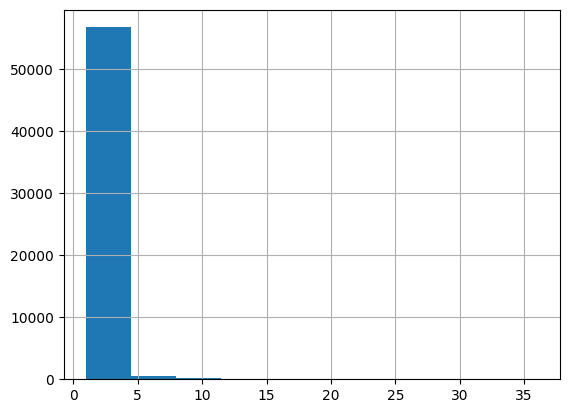

In [24]:
train_df['response_b_len'].hist()

<Axes: >

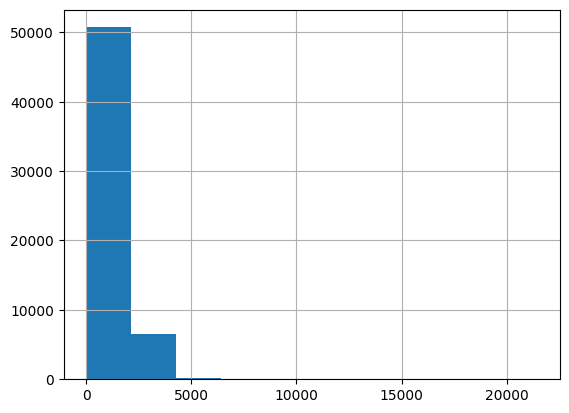

In [25]:
train_df['response_b_avg_len'].hist()

In [30]:
train_df['response_len'] = train_df['response_a_len']

In [46]:
test_df['response_len'] = test_df['response_a_len']

In [31]:
train_df.drop(['response_a_len', 'response_b_len'], axis=1, inplace=True)

In [40]:
test_df

,id,prompt,response_a,response_b,response_a_len,response_a_avg_len,response_b_len,response_b_avg_len
0,136060,"[I have three oranges today, I ate an orange y...",[You have two oranges today.],[You still have three oranges. Eating an orang...,1,27.0,1,110.0
1,211333,[You are a mediator in a heated political deba...,[Thank you for sharing the details of the situ...,[Mr Reddy and Ms Blue both have valid points i...,1,1445.0,1,456.0
2,1233961,[How to initialize the classification head whe...,[When you want to initialize the classificatio...,[To initialize the classification head when pe...,2,1980.0,2,1823.5


## Modelling

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import log_loss

from sklearn.metrics import f1_score

In [33]:
features = train_df[['response_a_avg_len', 'response_b_avg_len', 'response_len']]

# Combine the target columns into a single column with categorical values
# '0' for 'winner_model_a', '1' for 'winner_model_b', '2' for 'winner_tie'
conditions = [
    (train_df['winner_model_a'] == 1),
    (train_df['winner_model_b'] == 1),
    (train_df['winner_tie'] == 1)
]
choices = [0, 1, 2]
target = pd.Series(pd.Categorical(np.select(conditions, choices), categories=[0, 1, 2], ordered=True))

In [34]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.30, random_state=42)

In [35]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [36]:
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [37]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy of the multinomial logistic regression model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy of the multinomial logistic regression model: 0.4511134307585247
Confusion Matrix:
 [[3401 1849  817]
 [1889 3160  807]
 [2145 1958 1218]]


In [42]:
y_pred_proba = model.predict_proba(X_test)

y_pred_proba_clipped = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)  
logloss = log_loss(y_test, y_pred_proba_clipped)

In [43]:
logloss

1.0608372879616923

In [47]:
test_features = test_df[['response_a_avg_len', 'response_b_avg_len', 'response_len']]

test_features_normalized = scaler.transform(test_features)

test_probabilities = model.predict_proba(test_features_normalized)

output_df = pd.DataFrame({
    'id': test_df['id'],
    'winner_model_a': test_probabilities[:, 0], 
    'winner_model_b': test_probabilities[:, 1],
    'winner_tie': test_probabilities[:, 2]
})


In [49]:
output_df.to_csv('submission.csv', index=False)